In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

exch_1 = pd.read_csv ('../Downloads/coinmetrics.csv', sep = ',')
exch_2 = pd.read_csv ('../Downloads/bitcoincharts.csv', sep = ',')

exch_1['time'] = pd.to_datetime(exch_1['time'])
exch_1 = exch_1.loc[(pd.to_datetime ("2021-06-01") <= exch_1['time']) & (exch_1['time'] <= pd.to_datetime ("2022-05-31"))]

exch_2['Timestamp'] = pd.to_datetime(exch_2['Timestamp'])
exch_2 = exch_2.loc[(pd.to_datetime ("2021-06-01") <= exch_2['Timestamp']) & (exch_2['Timestamp'] <= pd.to_datetime ("2022-05-31"))]

В выгруженном датасете с coinmetrics столбцу "ReferenceRate" соответствует средневзвешенная цена за день, а столбцу "PriceUSD" - цена в конце дня (в полночь), фиксируемая службами coinmetrics, то есть "закрывающая цена" в этот день и "открывающая" в следующий. 

(Что касается аналогов столбцов "High" и "Low", то их либо нет в выгруженном с coinmetrics датасете, либо я не смог их найти в метриках на https://docs.coinmetrics.io/info/metrics)

In [2]:
exch_1[['time', 'ReferenceRate', 'PriceUSD']].head(10)

,time,ReferenceRate,PriceUSD
4532,2021-06-01,37312.974897,36661.378118
4533,2021-06-02,36661.378118,37639.455673
4534,2021-06-03,37639.455673,39160.150413
4535,2021-06-04,39160.150413,36884.373555
4536,2021-06-05,36884.373555,35409.567237
4537,2021-06-06,35409.567237,35720.604355
4538,2021-06-07,35720.604355,33724.907752
4539,2021-06-08,33724.907752,33475.048923
4540,2021-06-09,33475.048923,37372.988895
4541,2021-06-10,37372.988895,36826.002219


In [3]:
exch_2.head(10)

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
0,2021-06-01,37279.89,37927.44,35699.98,36693.30,4348.75,1.590917e+08,36583.28
1,2021-06-02,36693.30,38256.30,35933.19,37589.36,4270.10,1.595423e+08,37362.63
2,2021-06-03,37585.12,39490.00,37176.06,39219.88,4058.94,1.567207e+08,38611.21
3,2021-06-04,39242.94,39277.36,35576.67,36887.32,5786.19,2.137323e+08,36938.37
4,2021-06-05,36851.58,37927.93,34849.65,35532.14,4106.35,1.492555e+08,36347.50
5,2021-06-06,35532.59,36510.58,35250.00,35808.85,2526.73,9.074431e+07,35913.68
6,2021-06-07,35810.69,36808.30,33321.09,33582.62,4913.04,1.747388e+08,35566.34
7,2021-06-08,33567.51,34085.61,31025.00,33411.69,9044.65,2.954111e+08,32661.43
8,2021-06-09,33413.19,37556.25,32423.72,37400.00,8539.59,3.003795e+08,35174.95
9,2021-06-10,37414.64,38446.24,35824.69,36707.54,5761.72,2.138510e+08,37115.79


Видим, что данные не совпадают: столбцы "PriceUSD" в 1 таблице и "Close" во 2-ой различны, так же как и "ReferenceRate" с "Weighted Price".

Для вычисления Garman–Klass estimator with night jump correction воспользуемся следующей формулой:

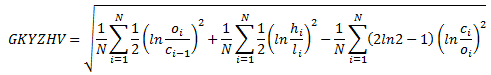

In [4]:
exch_2['close_prev'] = np.hstack ((np.array(0), exch_2.Close[:-1]))
exch_2.drop (labels = [0], axis = 0, inplace = True)

In [5]:
exch_2.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price,close_prev
1,2021-06-02,36693.30,38256.30,35933.19,37589.36,4270.10,1.595423e+08,37362.63,36693.30
2,2021-06-03,37585.12,39490.00,37176.06,39219.88,4058.94,1.567207e+08,38611.21,37589.36
3,2021-06-04,39242.94,39277.36,35576.67,36887.32,5786.19,2.137323e+08,36938.37,39219.88
4,2021-06-05,36851.58,37927.93,34849.65,35532.14,4106.35,1.492555e+08,36347.50,36887.32
5,2021-06-06,35532.59,36510.58,35250.00,35808.85,2526.73,9.074431e+07,35913.68,35532.14


In [6]:
GKYZHV_2 = np.sqrt ( np.mean (
    0.5 * np.square(np.log (exch_2.Open / exch_2.close_prev)) + 
    0.5 * np.square(np.log (exch_2.High / exch_2.Low)) - 
    (2 * np.log(2) - 1) * np.square(np.log (exch_2.Close / exch_2.Open))))
print (GKYZHV_2)

0.03884466679947443


Для первой таблицы значение GKYZHV посчитать не можем, так как неизвестны значения минимальной и максимальной цены за день.